# 2つのガウス分布を含む混合ガウス分布のためのEMアルゴリズム

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、2つの2次元ガウス分布を含む混合ガウス分布から生成されたデータについて、EMアルゴリズムでパラメータを求めるためのEMアルゴリズムの実装例です。

## アルゴリズムを適用される対象になるデータの生成

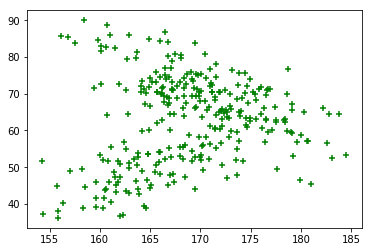

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# グループ1のガウス分布
mu1_ans = [170,70]
cov1_ans = [[6**2,-30],[-30,8**2]]
samples1 = np.random.multivariate_normal(mu1_ans,cov1_ans,200).T #サンプル生成

# グループ2のガウス分布
mu2_ans = [165,50]
cov2_ans = [[5.**2,20],[20,6**2]]
samples2 = np.random.multivariate_normal(mu2_ans,cov2_ans,100).T #サンプル生成

# 2つのグループを混ぜる
samples = np.column_stack((samples1,samples2))

# 描画
plt.scatter(samples[0],samples[1],color='g',marker='+')

## パラメータの初期設定

In [2]:
from scipy.stats import multivariate_normal

K = 2 #クラスタの数

def set_distribution(mu,cov):
    return multivariate_normal(mean=mu, cov=cov)

# 2つのガウス分布のオブジェクトを作る（Eステップでは固定）
mus = [[10*k+100,10*k] for k in range(K)] #分布の中心のリスト（初期位置をずらしておく）
covs = [[[100,0],[0,100]] for k in range(K)] #共分散のリスト
distributions = [set_distribution(mus[k],covs[k]) for k in range(K)] 

mixing_coefs = [1.0/K for k in range(K)] #混合係数のリスト

## Eステップの実装

分布を固定し、各サンプルがどっちの分布に属すかを負担率という値で返します。

In [3]:
def draw_gauss(d,X):
    # 分布とサンプルを描画
    for k in range(K):
        
        x, y = np.mgrid[(min(X[0])):(max(X[0])):1, (min(X[1])):(max(X[1])):1]
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x; pos[:, :, 1] = y
        plt.contour(x, y, d.pdf(pos),alpha=0.2)
        
def draw(ds,X):
    for d in ds: draw_gauss(d,X)    
    plt.scatter(X[0],X[1],color='g',marker='+')

def expectation_step(X,K,mus,covs,pis):    # 負担率の計算
    ans = [] # 負担率のリスト
    for n in range(len(X[0])): # サンプルの数（X座標の数X[0]でカウント）だけ繰り返し
        # サンプルの地点における各分布の値（密度）を計算
        ds = [ pis[k] * distributions[k].pdf([X[0][n],X[1][n]]) for k in range(K) ] 
        ans.append([ds[k]/sum(ds) for k in range(K)])

    return ans

### とりあえず1回Eステップを実行

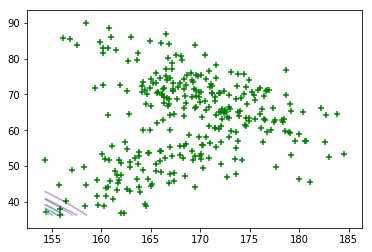

In [4]:
gammas = expectation_step(samples,K,mus,covs,mixing_coefs)
draw(distributions,samples)

## Mステップの実装

In [5]:
N = len(samples[0])
    
def maximization_step(k,mus,covs,pis,gammas): 
    N_k = sum ( [ gammas[n][k] for n in range(N) ])
    tmp_x = sum ( [ gammas[n][k] * samples[0][n] for n in range(N) ]) / N_k
    tmp_y = sum ( [ gammas[n][k] * samples[1][n] for n in range(N) ]) / N_k

    mu = [tmp_x,tmp_y]

    sigma = np.array([[0.0,0.0],[0.0,0.0]])
    for n in range(N):
        x = np.array([samples[0][n],samples[1][n]])
        d = (np.array([[samples[0][n],samples[1][n]]]) - np.array([mu])).T
        sigma += gammas[n][k] / N_k * d.dot(d.T)
        
    return mu, sigma, N_k/N

### とりあえず1回Mステップを実行

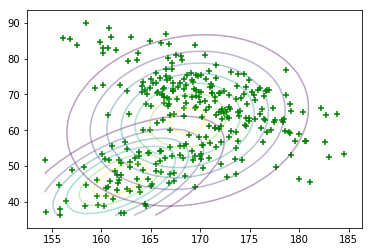

In [6]:
for k in range(K):
    mus[k], covs[k], mixing_coefs[k] = maximization_step(k,mus,covs,mixing_coefs,gammas)
    distributions[k] = set_distribution(mus[k],covs[k])
    
draw(distributions,samples)

## あと99回繰り返してみます

[3.6075756971089044e-05, 0.99996392424302849]
[0.076260733469710226, 0.92373926653029037]
[0.26835870432948417, 0.73164129567051583]
[0.32428455727853533, 0.67571544272146467]
[0.3287090090151189, 0.67129099098488121]
[0.32906148683043446, 0.67093851316956588]
[0.3290900938141012, 0.67090990618589852]
[0.32909241931219002, 0.67090758068780998]
[0.32909260837989646, 0.67090739162010316]
[0.32909262375165133, 0.67090737624834829]
[0.32909262492931668, 0.67090737507068254]


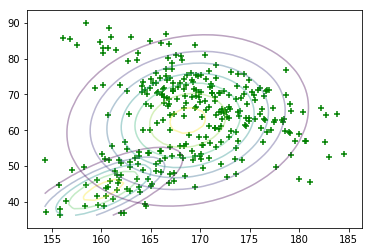

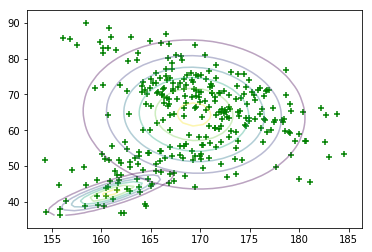

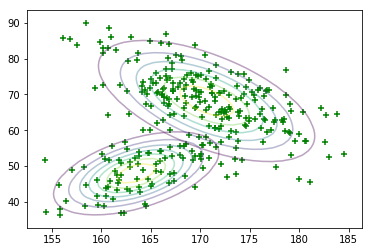

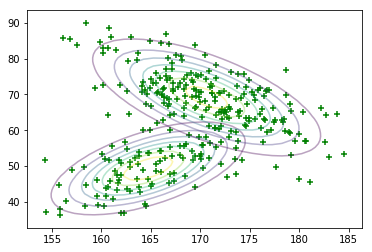

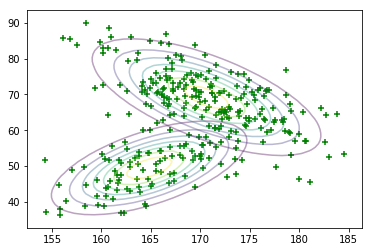

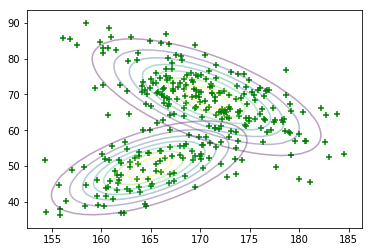

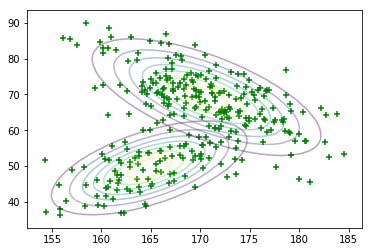

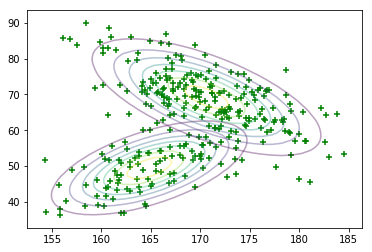

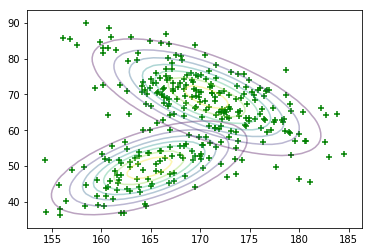

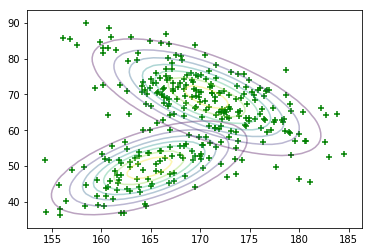

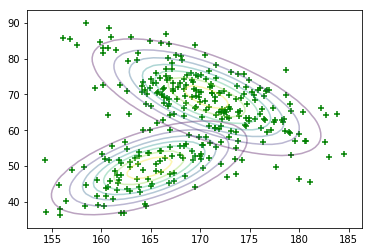

In [7]:
def one_step():
    gammas = expectation_step(samples,K,mus,covs,mixing_coefs)
    
    for k in range(K):
        mus[k], covs[k], mixing_coefs[k] = maximization_step(k,mus,covs,mixing_coefs,gammas)
        distributions[k] = set_distribution(mus[k],covs[k])

    
for i in range(99):
    one_step()
    
    if i %10 == 0:
        plt.figure()
        draw(distributions,samples)
        print(mixing_coefs)
        
plt.figure()
draw(distributions,samples)
print(mixing_coefs)